In [3]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
pd.options.display.max_columns = 100
%matplotlib inline

# Amendment Voting Model
This model will use how a member votes on a bill's amendments to predict they will vote on the bill itself.
## Feature Construction

In [4]:
# pull in model set row numbers
def get_full_set(path):
    for dataset in ['train','dev','test']:
        df = pd.read_csv(path + dataset + '.csv', encoding = 'latin1')
        if dataset == 'train':
            df_votes = df
        else:
            df_votes = pd.concat([df_votes, df])
    return df_votes
df_votes = get_full_set('../data/model/')

In [7]:
df_votes.shape

(1648863, 12)

In [19]:
# get all roll call votes with 'amendment' in the title for bills in model
df_rc = pd.read_csv('../data/propublica/votes_both.csv')
df_bills = pd.read_csv('../data/propublica/billsfull_model.csv', encoding = 'latin1')
df_rc = pd.merge(df_bills[['bill_id', 'last_vote']], df_rc, how = 'left', on = 'bill_id')
del df_bills
df_rc.dropna(subset=['question'], inplace = True)
df_rc = df_rc[df_rc.question.str.lower().str.contains("amendment")]
df_rc.reset_index(inplace = True, drop = True)

In [25]:
# get all member votes for amendment roll call votes
path = '../data/propublica/raw/'
errors = []
for i, row in df_rc.iterrows():
    # read in member amendment votes
    try:
        fname = row.chamber.lower()
        fname += "_" + str(int(row.congress))
        fname += "_" + str(int(row.session))
        fname += "_" + str(int(row.roll_call))
        df = pd.read_csv(path + "votes_roll_call_" + fname + '.csv')
    except:
        errors.append(i)
        continue
    columns = ['member_id', 'party', 'vote_position', 
               'congress', 'roll_call', 'session', 'date', 
               'majority_pos_rep', 'majority_pos_dem']
    df = df[columns]
    df['rc'] = fname
    df['bill_id'] = row.bill_id
    df['question'] = row.question
    df['result'] = row.result
    
    if i == 0:
        df_master = df
    else:
        df_master = pd.concat([df_master,df])
    
df_master.to_csv('../data/model/vote_history/amendment_votes_raw.csv', index = False)

# verify, filter, and standardize data
c1 = df_master.vote_position != 'Speaker'
c2 = df_master.vote_position != 'Present'
df_master = df_master[c1 & c2]
recode = {'Agreed to': 'Agreed', 
          'Passed': 'Agreed', 
          'Rejected': 'Failed', 
          'Amendment Rejected': 'Failed', 
          'Amendment Agreed to': 'Agreed', 
          'Motion Agreed to': 'Agreed'}
df_master['result'] = df_master.result.replace(recode)
df_master = df_master[df_master.result.isin(list(recode.values()))]
df_master = df_master[df_master.party.isin(['R', 'D'])]

def broke_am(row):
    party_position = row[{'R':'majority_pos_rep', 'D': 'majority_pos_dem'}[row.party]]
    if row.vote_position == party_position:
        return 0
    elif row.vote_position == 'Not Voting':
        return 0
    else:
        return 1
df_master['am_broke_wparty'] = df_master.apply(broke_am, axis = 1)

In [41]:
df_master.vote_position.value_counts()

No            810061
Yes           792150
Not Voting     49004
Name: vote_position, dtype: int64

In [52]:
df_master.result.value_counts()

Failed    1067997
Agreed     583018
Name: result, dtype: int64

In [68]:
df_master.am_broke_wparty.mean()

0.11607886209449374

In [96]:
# perform groupbys to get relevant statistics for each bill X member combination
row_id = ['member_id', 'bill_id']
df = df_master.groupby(row_id + ['vote_position', 'result']).size().unstack().unstack().reset_index()

def format_vote_count(row, outcome):
    """Calculates vote percent for each amendment outcome type
        There is def a fancy pandas way of doing this, but i'm lazy"""
    if row[outcome].isnull().all():
        return [-1,-1,-1, 0]
    am_count = row[outcome].sum()
    vote_count = row[outcome].fillna(0)
    vote_count = vote_count / am_count
    
    return vote_count.tolist() + [am_count]

df_ams = df[row_id]
for outcome in ['Agreed','Failed']:
    df_sub = df.apply(format_vote_count, outcome = outcome, axis = 1).tolist()
    cols = [outcome + x for x in ['_no','_skipped', '_yes', '_amcount']]
    df_sub = pd.DataFrame(df_sub, columns=cols)
    df_ams = pd.concat([df_ams, df_sub], axis = 1)
df_ams.rename(columns={('member_id',""): 'member_id', ('bill_id',""): 'bill_id'}, inplace = True)

df = df_master.groupby(row_id + ['result']).am_broke_wparty.mean().unstack()
df.columns = [x + "_broke_pct" for x in df.columns]
df = df.reset_index()
df.fillna(-1, inplace = True)
df_ams = pd.merge(df_ams, df, on = row_id)
df = pd.DataFrame(df_master.groupby(row_id).am_broke_wparty.mean())
df.reset_index(inplace=True)
df_ams = pd.merge(df_ams, df, on = row_id)

In [124]:
# pull in model set row numbers
def get_full_set(path):
    for dataset in ['train','dev','test']:
        df = pd.read_csv(path + dataset + '.csv', encoding = 'latin1')
        if dataset == 'train':
            df_votes = df
        else:
            df_votes = pd.concat([df_votes, df])
    return df_votes

df_votes = get_full_set('../data/model/')
df_votes = df_votes.drop_duplicates(subset=row_id)[row_id + ['full_set_id']]
df_ams = pd.merge(df_ams, df_votes, how = 'left', on = row_id)
df_ams.to_csv('../data/model/vote_history/amendment_votes_processed.csv', index = False)
df_ams.drop(row_id, axis = 1, inplace=True)

## Model

In [141]:
features = [x for x in df_ams.columns if x not in ['full_set_id', 'member_id', 'bill_id']]

In [139]:
test = pd.read_csv('../data/model/test.csv')
train = pd.read_csv('../data/model/train.csv')
dev = pd.read_csv('../data/model/dev.csv')
dfs = [train, dev, test]
def join_features(df):
    df = pd.merge(df, df_ams, on = 'full_set_id', how = 'left').dropna(subset = ['Agreed_no'])
    return df
model_train, model_dev, model_test =  map(join_features, dfs)

In [161]:
# break with party rate is much higher for this subset of data (bills with ammendment votes)
model_train.broke_from_party.mean()

0.09317976141505553

In [142]:
# baseline if randomly assign 1 at level proportional to overall rate
t = [1] * int(len(model_dev) * model_train.broke_from_party.mean())
t += ([0] *(len(model_dev) - len(t)))
t = shuffle(t)
print(metrics.classification_report(model_dev['broke_from_party'], t, digits=4))

             precision    recall  f1-score   support

          0     0.9074    0.9063    0.9069     81750
          1     0.0865    0.0876    0.0871      8283

avg / total     0.8319    0.8310    0.8314     90033



In [154]:
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=40)
rfc.fit(model_train[features], model_train['broke_from_party'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


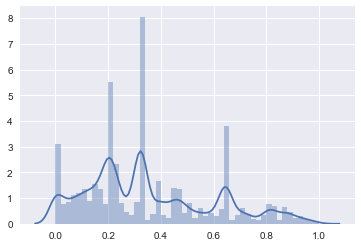

In [155]:
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [158]:
thresh = .73
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

7810
             precision    recall  f1-score   support

          0     0.9396    0.9451    0.9424     81750
          1     0.4251    0.4008    0.4126      8283

avg / total     0.8923    0.8950    0.8936     90033



In [162]:
def export_predictions(dfs, model, file_name, 
                       path = "../data/model/model_predictions/", 
                       predictors = features):
    """Exports probabilities for all sets
    Args:
        dfs: train, dev, test sets. in that order.
        model: sklearn model to get predictions
        path: where to export
        predictors: Column set to use as predictors
    """
    labels = ['train', 'dev', 'test']
    for label, df in zip(labels, dfs):
        probs = model.predict_proba(df[predictors])[:,1]
        probs = pd.DataFrame(probs, index = df.full_set_id, columns=['pred_probs'])
        probs.to_csv(path + file_name + "_" + label + ".csv")

with open('../data/model/vote_history/rfc_amendments.pickle', 'wb') as f:
    pickle.dump(rfc, f)
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, rfc, 'amendment_votes', predictors=features)

In [20]:
df_rc.head()

,bill_id,last_vote,bill,chamber,congress,date,democratic,description,independent,question,republican,result,roll_call,session,source,time,total,url,vote_type,vote_uri,sponsor_id,majority_pos_rep,majority_pos_dem,majority_pos_ind
0,hr1432-105,1998-03-11,{u'api_uri': u'https://api.propublica.org/cong...,House,105.0,1998-03-11,"{u'not_voting': 12, u'yes': 25, u'majority_pos...","Bereuter of Nebraska Amendment, As Modified","{u'not_voting': 0, u'yes': 0, u'present': 0, u...",On Agreeing to the Amendment,"{u'not_voting': 4, u'yes': 131, u'majority_pos...",Failed,45.0,2.0,http://clerk.house.gov/evs/1998/roll045.xml,16:31:00,"{u'not_voting': 16, u'yes': 156, u'present': 0...",http://clerk.house.gov/evs/1998/roll045.xml,RECORDED VOTE,https://api.propublica.org/congress/v1/105/hou...,C000873,Yes,No,No
1,hr1432-105,1998-03-11,{u'api_uri': u'https://api.propublica.org/cong...,House,105.0,1998-03-11,"{u'not_voting': 10, u'yes': 77, u'majority_pos...",Waters of California Amendment,"{u'not_voting': 0, u'yes': 1, u'present': 0, u...",On Agreeing to the Amendment,"{u'not_voting': 5, u'yes': 3, u'majority_posit...",Failed,44.0,2.0,http://clerk.house.gov/evs/1998/roll044.xml,16:23:00,"{u'not_voting': 15, u'yes': 81, u'present': 0,...",http://clerk.house.gov/evs/1998/roll044.xml,RECORDED VOTE,https://api.propublica.org/congress/v1/105/hou...,C000873,No,No,Yes
2,hr503-109,2006-09-07,{u'api_uri': u'https://api.propublica.org/cong...,House,109.0,2006-09-07,"{u'not_voting': 11, u'yes': 36, u'majority_pos...",King of Iowa Amendment,"{u'not_voting': 0, u'yes': 0, u'present': 0, u...",On Agreeing to the Amendment,"{u'not_voting': 15, u'yes': 113, u'majority_po...",Failed,432.0,2.0,http://clerk.house.gov/evs/2006/roll432.xml,14:40:00,"{u'not_voting': 26, u'yes': 149, u'present': 1...",http://clerk.house.gov/evs/2006/roll432.xml,RECORDED VOTE,https://api.propublica.org/congress/v1/109/hou...,S001149,None,No,No
3,hr503-109,2006-09-07,{u'api_uri': u'https://api.propublica.org/cong...,House,109.0,2006-09-07,"{u'not_voting': 11, u'yes': 46, u'majority_pos...",Goodlatte of Virginia Amendment,"{u'not_voting': 0, u'yes': 0, u'present': 0, u...",On Agreeing to the Amendment,"{u'not_voting': 14, u'yes': 131, u'majority_po...",Failed,431.0,2.0,http://clerk.house.gov/evs/2006/roll431.xml,14:32:00,"{u'not_voting': 25, u'yes': 177, u'present': 1...",http://clerk.house.gov/evs/2006/roll431.xml,RECORDED VOTE,https://api.propublica.org/congress/v1/109/hou...,S001149,Yes,No,No
4,s679-112,2012-07-31,{u'api_uri': u'https://api.propublica.org/cong...,Senate,112.0,2011-06-29,"{u'not_voting': 1, u'yes': 2, u'majority_posit...",To enhance accountability and transparency amo...,"{u'not_voting': 0, u'yes': 0, u'present': 0, u...",On the Amendment,"{u'not_voting': 0, u'yes': 23, u'majority_posi...",Amendment Rejected,100.0,1.0,https://www.senate.gov/legislative/LIS/roll_ca...,11:35:00,"{u'not_voting': 1, u'yes': 25, u'present': 0, ...",https://www.senate.gov/legislative/LIS/roll_ca...,1/2,https://api.propublica.org/congress/v1/112/sen...,S000148,No,No,No
